# Exploration de données temporelles avec Matlab

Pierre Haessig & Marie-Anne Lefèbvre – octobre 2019

Vérification version Matlab: R2018b attendu

In [1]:
disp(version) 

9.5.0.1178774 (R2018b) Update 5


Configuration : affichage des graphiques "inline" (cf imatlab's [README](https://github.com/imatlab/imatlab#inline-graphics))

In [2]:
imatlab_export_fig('print-png')  % Static png figures.
%imatlab_export_fig('')  % Native windows.

## 1) Chargement & prétraitements des données

### Charger fichier de données avec `readtable`

Objectif : charger le fichier `data/meteo_rennes_2015.txt`

In [3]:
opts = detectImportOptions('data/meteo_rennes_2015.txt')


opts = 

  DelimitedTextImportOptions with properties:

   Format Properties:
                    Delimiter: {'\t'  ' '}
                   Whitespace: '\b'
                   LineEnding: {'\n'  '\r'  '\r\n'}
                 CommentStyle: {}
    ConsecutiveDelimitersRule: 'join'
        LeadingDelimitersRule: 'ignore'
                EmptyLineRule: 'skip'
                     Encoding: 'windows-1252'

   Replacement Properties:
                  MissingRule: 'fill'
              ImportErrorRule: 'fill'
             ExtraColumnsRule: 'addvars'

   Variable Import Properties: Set types by name using setvartype
                VariableNames: {'Var1', 'Var2', 'Var3' ... and 9 more}
                VariableTypes: {'double', 'double', 'double' ... and 9 more}
        SelectedVariableNames: {'Var1', 'Var2', 'Var3' ... and 9 more}
              VariableOptions: [1x12 matlab.io.NumericVariableImportOptions] 
	Access VariableOptions sub-properties using setvaropts/getvaropts

   Location Prope

[readtable](https://fr.mathworks.com/help/matlab/ref/readtable.html): Create table from file

In [4]:
meteo = readtable('data/meteo_rennes_2015.txt', opts);

[head](https://fr.mathworks.com/help/matlab/ref/head.html): Get top rows of table, timetable, or tall array

In [5]:
head(meteo, 3)


ans =

  3x12 table

    Var1    Var2    Var3    Var4    Var5    Var6    Var7     Var8    Var9    Var10    Var11    Var12
    ____    ____    ____    ____    ____    ____    _____    ____    ____    _____    _____    _____

    2015     1       1       0      -25     -35     10376    140      15       0      -9999        0
    2015     1       1       1      -30     -40     -9999    150      10       0      -9999    -9999
    2015     1       1       2      -30     -40     -9999    150      10       0      -9999    -9999



Cosmétique (facultatif) : renommage des noms des colonnes via les [table.Properties](https://fr.mathworks.com/help/matlab/ref/table.html#mw_cb8d6608-0cf9-4164-b1f8-7bce6caa23ce)

In [6]:
meteo.Properties.VariableNames(1) = {'Annee'};
meteo.Properties.VariableNames(2) = {'Mois'};
meteo.Properties.VariableNames(3) = {'Jour'};
meteo.Properties.VariableNames(4) = {'Heure'};
meteo.Properties.VariableNames(5) = {'Temp'};

Mise à l'échelle de la température (cf. documentation du jeu de données [data/ISD-Lite 2006 format.pdf](data/ISD-Lite%202006%20format.pdf))

In [7]:
meteo.Temp = meteo.Temp/10;

In [8]:
head(meteo, 3)


ans =

  3x12 table

    Annee    Mois    Jour    Heure    Temp    Var6    Var7     Var8    Var9    Var10    Var11    Var12
    _____    ____    ____    _____    ____    ____    _____    ____    ____    _____    _____    _____

    2015      1       1        0      -2.5    -35     10376    140      15       0      -9999        0
    2015      1       1        1        -3    -40     -9999    150      10       0      -9999    -9999
    2015      1       1        2        -3    -40     -9999    150      10       0      -9999    -9999



Copie d'une colonne dans une autre variable

In [10]:
Temp = meteo.Temp;
Temp(1:3)


ans =

   -2.5000
   -3.0000
   -3.0000



Remarque : `Temp` est matrice (array) « classique » de Matlab. Si on veut extraire une colonne en gardant le type `table`, il faut utiliser la syntaxe de slicing

In [149]:
class(meteo.Temp)
class(meteo(:,'Temp'))


ans =

    'double'


ans =

    'table'



### Données manquantes ou aberrantes

Température moyenne : fait-il si froid à Rennes !?

In [12]:
mean(Temp)


ans =

    0.0876



Réponse : non, il y a « juste » des données **abberrantes**.


<div style="background:#d7ffb0;border: 1px solid #4ea000;padding:5px;">
    Bonne pratique : toujours <strong>regarder</strong> les données avant de les utiliser. Par exemple avec plot ou histogram.
</div>

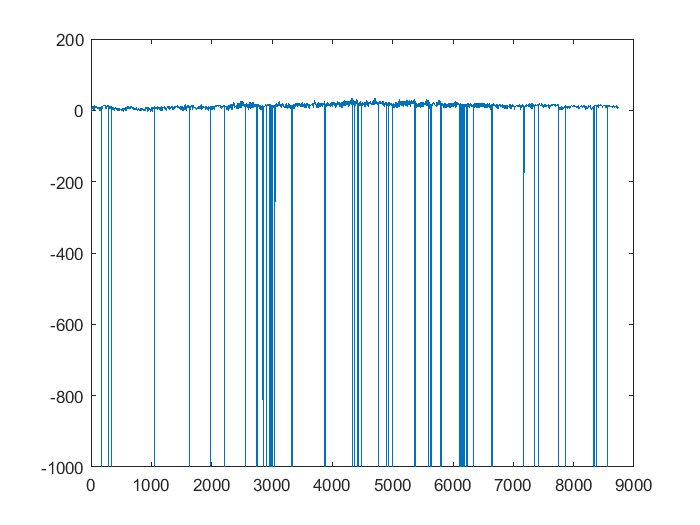

In [13]:
plot(Temp)

In [14]:
min(Temp)


ans =

 -999.9000



La raison du problème : les données manquantes sont notées -9999 dans le fichier (cf. documentation du jeu de données [data/ISD-Lite 2006 format.pdf](data/ISD-Lite%202006%20format.pdf)). La mise à l'échelle a transformée cette valeur en -999.9

Solution : marquer ces valeurs comme manquante

* Doc : [Missing Data in MATLAB](https://fr.mathworks.com/help/matlab/data_analysis/missing-data-in-matlab.html)
* fonction [missing](https://fr.mathworks.com/help/matlab/ref/missing.html): Create missing values → renvoi un `NaN` dans un contexte de tableau de nombres

In [26]:
% Démo de missing utilisé dans un tableau de nombres
[1 missing 3]


ans =

     1   NaN     3



Pour cela, on peut se servir du [logical indexing](https://blogs.mathworks.com/steve/2008/01/28/logical-indexing/) (syntaxe très utile en Matlab, mais aussi avec les tableau numpy en Python)

In [15]:
Temp_bad = Temp == -999.9;  %crée en logical array
Temp_bad(1:3)


ans =

  3x1 logical array

   0
   0
   0



Ce vecteur logique peut servir à répondre à quelques questions intéressantes :

* Combien y a-t-il de valeurs absurdes ? → Somme du vecteur
* Quelle est la proportion de valeurs absurdes ? → Moyenne du vecteur

In [17]:
disp(sum(Temp_bad))
disp(mean(Temp_bad)*100) % en %

   105

    1.2015



#### Marquer les valeurs aberrantes comme manquantes

L'indexation logique permet de sélectionner les indices `k` pour lequel `Temp_bad(k)` est vrai, cad les valeurs aberrantes. Et on peut faire une assignation sur ces valeurs

In [18]:
Temp(Temp_bad) = missing;

Par exemple, on peut voir une valeur manquante à l'indice 175:

In [21]:
disp(Temp(172:178))

   10.3000
   10.7000
   10.7000
       NaN
   11.3000
   11.7000
   11.2000



Cependant, il n'y a pas seulement des données aberrantes, mais il y a aussi des **données non enregistrées**, cad des lignes manquantes dans le fichier

Avec [height](https://fr.mathworks.com/help/matlab/ref/height.html) (longueur du tableau) on peut voir qu'il y a moins de lignes que d'heure dans l'années 2015

In [22]:
365*24 - height(meteo)


ans =

    21



Attention, les changements de la variable `Temp` ne sont pas reproduits dans `meteo.Temp`, car c'était une copie. Il faut donc faire la copie dans l'autre sens

In [23]:
meteo.Temp = Temp;

A présent, le tracé de la température a bonne allure, mais...

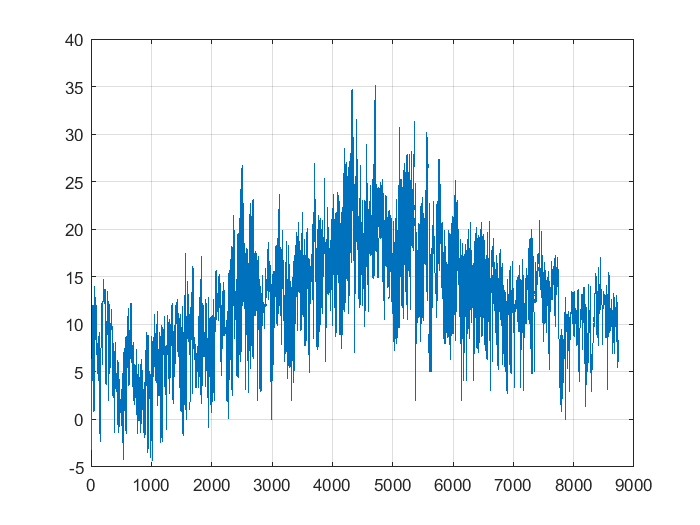

In [24]:
plot(Temp)
grid on;

... mais attention, les NaNs *ne sont pas détectables* sur le graphique, même s'ils sont bien présents. Exemple avec un zoom autour de l'indice 2200. 

Et par ailleurs, les 21 lignes manquantes ne sont *pas du tout visibles*, car on ne fait pas un tracé fonction du temps mais des indices.

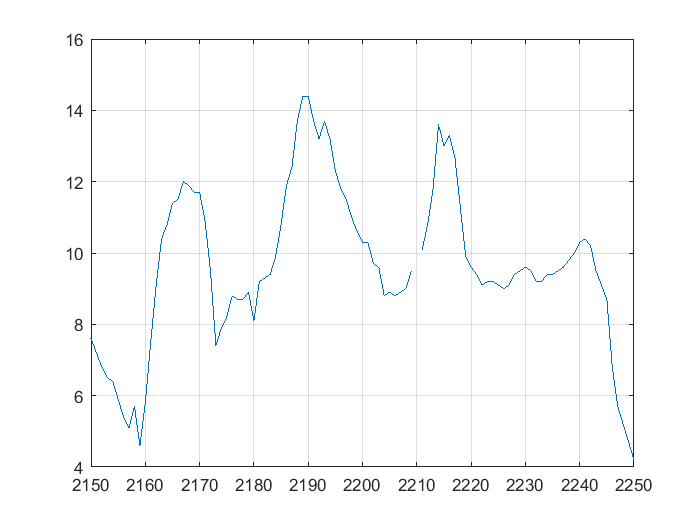

In [25]:
plot(Temp)
xlim([2170 2220])
grid on;

#### Statistiques avec valeurs manquantes

Calcul de la moyenne : attention à la propagation des NaNs.

Doc de référence: [Data with Missing Values](https://fr.mathworks.com/help/stats/data-with-missing-values.html)

In [30]:
1 + NaN


ans =

   NaN



In [27]:
disp(mean(Temp))

   NaN



Et donc il a fait 12.2°C en moyenne à Rennes en 2015:

In [28]:
disp(nanmean(Temp))

   12.2487



Pour voir la répartition des données : histogramme 

cf. [histogram](https://fr.mathworks.com/help/matlab/ref/matlab.graphics.chart.primitive.histogram.html)

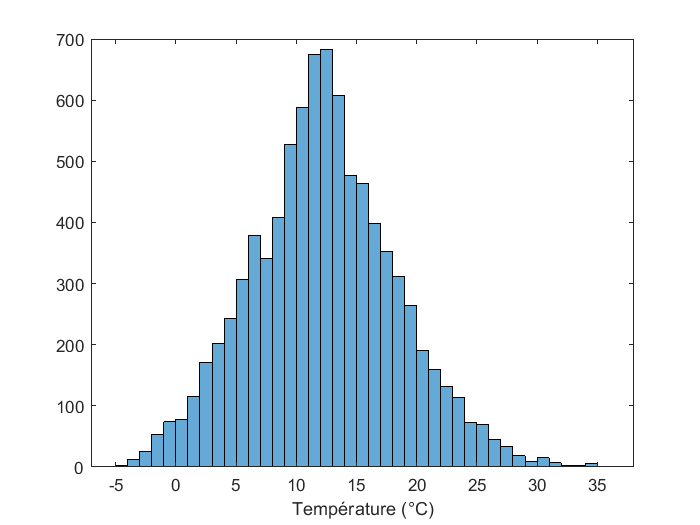

In [29]:
histogram(Temp)
xlabel('Température (°C)')

### Dates : parsing (décodage) et représentation

Fonction constructeur [datetime](https://fr.mathworks.com/help/matlab/ref/datetime.html): Arrays that represent points in time.

Le type compagnon est [duration](https://fr.mathworks.com/help/matlab/ref/duration.html), que l'on peut créer succintement avec `days`, `hours`…

In [33]:
% Démo de l'arithmétique des datetime et duration:
d = datetime('2019-09-25');
days(3); % ou : days * 3
disp(d + days(3))

   28-Sep-2019 00:00:00



Datetime pour le fichier météo à Rennes :

In [34]:
meteo_date = datetime(meteo.Annee, meteo.Mois, meteo.Jour,...
                      meteo.Heure, 0,0);
meteo_date(1:3)


ans = 

  3x1 datetime array

   01-Jan-2015 00:00:00
   01-Jan-2015 01:00:00
   01-Jan-2015 02:00:00



In [35]:
disp(class(meteo_date))

datetime


#### Conversion table → timetable

Une fois la date décodée, le conteneur `table` peut être converti en `timetable` qui facilite le traitement des données horodatées. 
*(introduced in R2016b)*.

cf [Timetables](https://fr.mathworks.com/help/matlab/timetables.html) doc

In [36]:
meteo_TT = table2timetable(meteo, 'RowTimes', meteo_date);
head(meteo_TT, 3)


ans =

  3x12 timetable

            Time            Annee    Mois    Jour    Heure    Temp    Var6    Var7     Var8    Var9    Var10    Var11    Var12
    ____________________    _____    ____    ____    _____    ____    ____    _____    ____    ____    _____    _____    _____

    01-Jan-2015 00:00:00    2015      1       1        0      -2.5    -35     10376    140      15       0      -9999        0
    01-Jan-2015 01:00:00    2015      1       1        1        -3    -40     -9999    150      10       0      -9999    -9999
    01-Jan-2015 02:00:00    2015      1       1        2        -3    -40     -9999    150      10       0      -9999    -9999



#### Analyse de l'échantillonnage

L'inspection superficielle de l'archive météo montre un enregistrement toutes les heures, mais est-ce vraiement périorique ([isregular(TT)](https://fr.mathworks.com/help/matlab/ref/timetable.isregular.html)). Réponse : non (on a vu plus haut qu'il manque 21 heures)

In [85]:
disp(isregular(meteo_TT))

   0



Si on veut plus de détail, la fonction Matlab classique `diff` (filtre $y_k = u_k -u_{k-1}$) fonctionne aussi avec les tableaux `datetime` (elle renvoie un tableau de `duration`) :

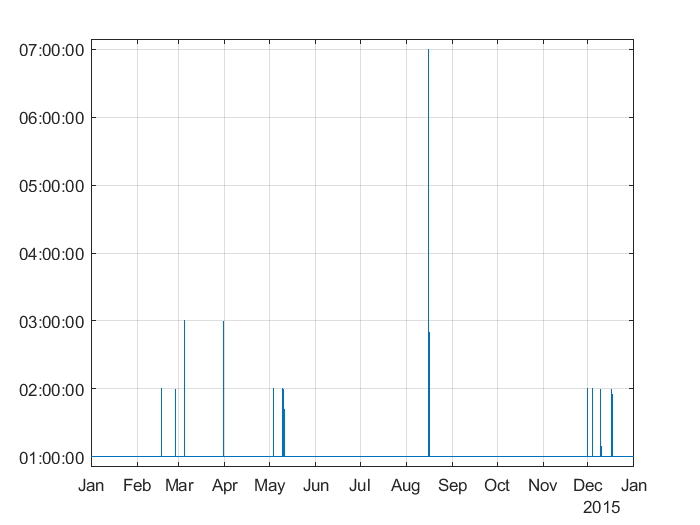

In [88]:
plot(meteo_TT.Time(1:end-1), diff(meteo_TT.Time))
grid on

#### Sélectionner un intervalle de temps

Exemple : mois de juin 

méthode 1 (plus générique) avec une indexation par un [timerange](https://fr.mathworks.com/help/matlab/ref/timerange.html)

In [37]:
TR = timerange('2015-06-01','2015-07-01');
meteo_juin = meteo_TT(TR, :);
disp(nanmean(meteo_juin.Temp))

   17.1027



méthode 2 (plus spécifique) : avec logical indexing

In [38]:
meteo_juin2 = meteo(meteo_date.Month==6, :);
disp(nanmean(meteo_juin2.Temp))

   17.1027



À présent, le tracé temporel peut se faire avec les dates, en fournissant le vecteur de datetime en abscisse de `plot`:

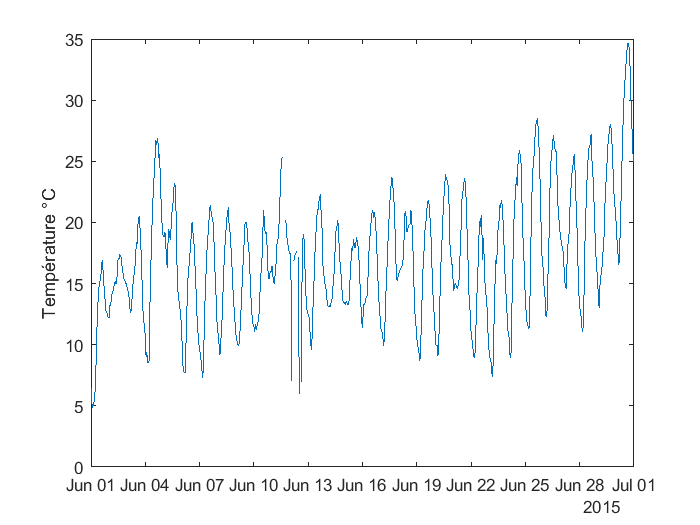

In [43]:
plot(meteo_juin.Time, meteo_juin.Temp)
title('Rennes, juin 2015')
ylabel('Température °C')

Rappel : un histogramme est toujours utile, par exemple pour constater, sans faire de tracé temporel, que la température peut descendre jusqu'à 5°C en juin !

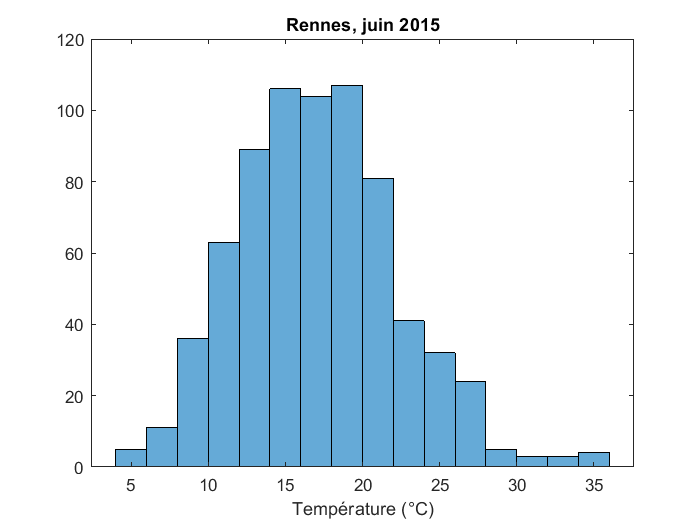

In [40]:
histogram(meteo_juin2.Temp)
title('Rennes, juin 2015')
xlabel('Température (°C)')

## 2) Mise en forme & synchronisation de données

Fichiers : log capteur de qualité de l’air salle 404 (et archive météo)

Aperçu de `log-20150309-171821.csv` :
```
date;time;type;value;unit
09/03/2015;17:18:29.244;carbon dioxide;1630;ppm
09/03/2015;17:19:12.416;indoor relative humidity;37.0;%
09/03/2015;17:20:12.689;indoor relative humidity;37.0;%
```
→ Un beau fichier CSV bien formaté, séparé par des `;`, avec des nombres et du texte

In [45]:
%% Chargement données capteur qualité de l'air
log = readtable('./data/log-20150309-171821.csv');
disp(head(log, 3))

       date           time                   type               value    unit 
    __________    ____________    __________________________    _____    _____

    09/03/2015    17:18:29.244    'carbon dioxide'              1630     'ppm'
    09/03/2015    17:19:12.416    'indoor relative humidity'      37     '%'  
    09/03/2015    17:20:12.689    'indoor relative humidity'      37     '%'  



Observation sur les dates :
* la colonne `date` est bien parsée en `datetime`
* la colonne `time` est bien parsée en `duration`

In [46]:
disp(class(log.date)) % datetime
disp(class(log.time)) % duration

datetime
duration


Cependant, dans Matlab R2017b, colonne `time` n'était pas parsée. Il fallait faire le décodage à la main:

In [ ]:
% log_time = datetime(log.time, 'InputFormat', 'HH:mm:ss.SSS');
% log_time = timeofday(log_time); % datetime → duration

Combinaison de la date et de l'heure : addition. Cependant, l'affichage est *trompeur* (Note : sur la version de Matlab 2018b de la salle 409, il n'y a pas ce problème…)

In [49]:
log_datetime = log.date + log.time;
disp(log_datetime(1:3))

   09/03/2015
   09/03/2015
   09/03/2015



**À lire absolument** : [datetime.Format](https://fr.mathworks.com/help/matlab/ref/datetime.html#buhzxmk-1-Format)

In [51]:
log_datetime.Format


ans =

    'dd/MM/uuuu'



En attribuant à `log_datetime` une chaine de formattage plus adaptée, on obtient un affichage approprié :

In [53]:
%log_datetime.Format = 'default';
log_datetime.Format = 'yyyy-MM-dd HH:mm:ss.SSS';
disp(log_datetime(1:3))

   2015-03-09 17:18:29.244
   2015-03-09 17:19:12.416
   2015-03-09 17:20:12.689



Conversion en Timetable:

In [54]:
log_TT = table2timetable(log, 'RowTimes', log_datetime);
disp(head(log_TT, 3))

             Time                 date           time                   type               value    unit 
    _______________________    __________    ____________    __________________________    _____    _____

    2015-03-09 17:18:29.244    09/03/2015    17:18:29.244    'carbon dioxide'              1630     'ppm'
    2015-03-09 17:19:12.416    09/03/2015    17:19:12.416    'indoor relative humidity'      37     '%'  
    2015-03-09 17:20:12.689    09/03/2015    17:20:12.689    'indoor relative humidity'      37     '%'  



De façon générale, le datetime Format est la seule solution pour parser des dates suffisamment bizarres pour que Matlab ne détecte pas le format tout seul. Exemple :

In [55]:
dates_bizarres = {'01/09/2019 à 01h25' '01/10/2019 à 02h45'};
datetime(dates_bizarres)

Error using datetime (line 635)
Could not recognize the format of the date/time text. You can specify a format using the 'InputFormat' parameter. If the date/time text contain day, month, or time zone names in a language foreign to the 'en_US' locale, those might not be recognized. You can specify a different locale using the 'Locale' parameter.


In [56]:
disp(datetime(dates_bizarres, 'InputFormat', 'dd/MM/yyyy à HH''h''mm' ))

   01-Sep-2019 01:25:00   01-Oct-2019 02:45:00



### Données catégorielles & Statistiques par groupes

Certaines données sont à valeur discrète. Elle sont appelées « [variables catégorielles](https://fr.wikipedia.org/wiki/Variable_cat%C3%A9gorielle) » Exemples :

* Fichier météo à Rennes : Mois = 1, 2, 3... (entier)
* Log capteur : type = 'carbon dioxide', ... (chaîne de caractères)
* Champs `Month`, `Day`, `Hour`… d’un tableau `datetime`

Pour les catégories numériques, pas de problème, mais par contre le catégoriée représentées par des chaînes de caractères sont très inefficaces.
Il y a une alternative dédiée et beaucoup plus efficace : le type [categorical](https://fr.mathworks.com/help/matlab/ref/categorical.html) (voir aussi doc [Categorical Arrays](https://fr.mathworks.com/help/matlab/categorical-arrays.html)).

In [59]:
% log.type est un cell array de chaine de caractères
disp(class(log.type))
disp(class(log.type{1}))

cell
char


Colonne `type` : 118 008 chaines de caractères, pesant 18 Mo

In [60]:
type = log.type;
whos type

  Name           Size               Bytes  Class    Attributes

  type      118008x1             18202288  cell               



La conversion en [categorical](https://fr.mathworks.com/help/matlab/ref/categorical.html) ramène le poids à peine plus de 118 ko (~1 octet par élément)

In [61]:
type = categorical(type);
whos type

  Name           Size             Bytes  Class          Attributes

  type      118008x1             118916  categorical              



Note : on peut observer la disparition des `'` dans la colonne `type` (et on pourrait appliquer la même conversion à la colonne `unit`)

In [62]:
log.type = type;
disp(head(log, 3))

       date           time                  type              value    unit 
    __________    ____________    ________________________    _____    _____

    09/03/2015    17:18:29.244    carbon dioxide              1630     'ppm'
    09/03/2015    17:19:12.416    indoor relative humidity      37     '%'  
    09/03/2015    17:20:12.689    indoor relative humidity      37     '%'  



Fonctions utiles :
* lister toutes les catégories contenues dans un vecteur: `unique` ou `categories` (renvoient respectivement un categorical ou un cell array de strings)
* conter les occurences de chaque categories: [countcats](https://fr.mathworks.com/help/matlab/ref/categorical.countcats.html)

In [63]:
unique(type)


ans = 

  6x1 categorical array

     carbon dioxide 
     indoor relative humidity 
     indoor temperature 
     outdoor temperature 
     solar Irradiance 
     volatile organic compounds 



In [64]:
categories(type)


ans =

  6x1 cell array

    {'carbon dioxide'            }
    {'indoor relative humidity'  }
    {'indoor temperature'        }
    {'outdoor temperature'       }
    {'solar Irradiance'          }
    {'volatile organic compounds'}



Comptage : on en déduit que c'est pour 'indoor relative humidity' que l'on a le plus de mesures.

In [66]:
countcats(type)


ans =

       17612
       52842
       17610
        1902
       10429
       17613



#### Statistiques par groupes, boxplot

Les variables catégorielles peuvent servir de [Grouping Variables](https://fr.mathworks.com/help/stats/grouping-variables.html), par exemple pour :
* calculer des [statistiques par groupes](https://fr.mathworks.com/help/stats/summary-statistics-grouped-by-category.html) (⚠) (avec fonction [grpstats](https://fr.mathworks.com/help/stats/grpstats.html))
* tracer un [boxplot](https://fr.mathworks.com/help/stats/boxplot.html).

(⚠) Attention: ce guide utilise le type données `dataset array` qui est déprécié au profit de `table`.

Boxplot: 

Pour une comparaison rapide de la distribution de la température *pour chaque mois* : boxplot, en utilisant la variable Mois pour le regroupement

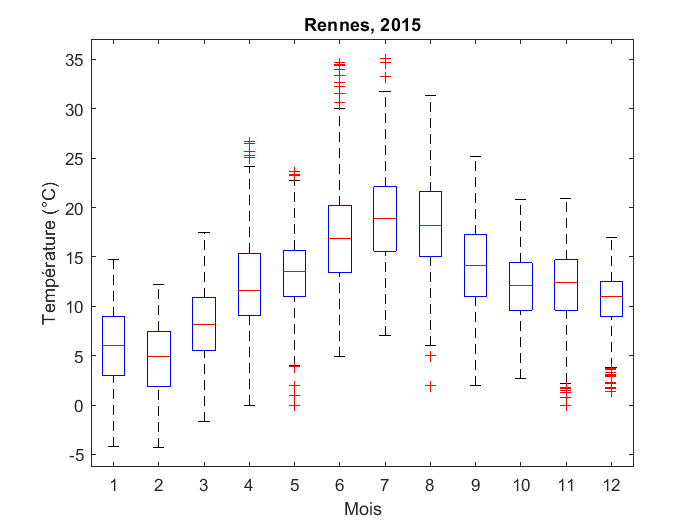

In [73]:
boxplot(meteo.Temp, meteo.Mois)

xlabel('Mois')
ylabel('Température (°C)')
title('Rennes, 2015')
% Amélioration: remplacer le xticklabels numérique par le nom des mois
% xticklabels({'Jan',  'Fév','Mar', '...'})

Statistiques par groupes :

Avec [grpstats](https://fr.mathworks.com/help/stats/grpstats.html)
on peut obtenir les données sous-jacentes du boxplot, comme la moyenne mois par mois :

In [68]:
Temp_by_month_avg = grpstats(meteo.Temp, meteo.Mois, 'mean');

Et l'on peut aussi calculer plusieurs stats d'un seul coup, par exemple min et max (toujours mois par mois) :

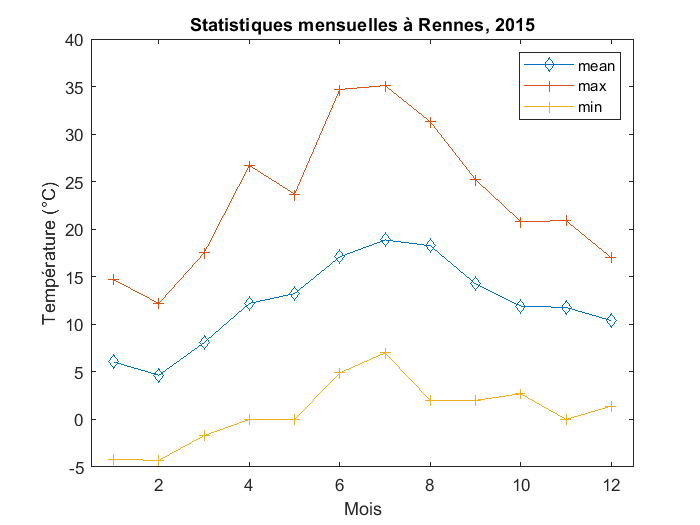

In [89]:
[Temp_by_month_max, Temp_by_month_min]  = grpstats(meteo.Temp, meteo.Mois, {'max', 'min'});
plot(Temp_by_month_avg, '-d')
hold on
plot(Temp_by_month_max, '-+')
plot(Temp_by_month_min, '-+')
legend('mean', 'max', 'min')


xlabel('Mois')
xlim([0.5, 12.5])
ylabel('Température (°C)')
title('Statistiques mensuelles à Rennes, 2015')

### Empilement/désempilement

Les données du capteur de qualité de l'air sont dans un format dit "long" ([vs "narrow"](https://en.wikipedia.org/wiki/Wide_and_narrow_data)) aussi appelé "empilé" (EN : "stacked").

Pour récupére un seul type de mesure, le logical indexing est suffisant

In [76]:
is_Temp_in = type == 'indoor temperature';
disp(mean(is_Temp_in)) % proportion de mesures de ce type parmi toutes les mesures

    0.1492



Extraction des données de température intérieur, extérieur et concentration CO2 :

In [94]:
Temp_in = log_TT(type == 'indoor temperature', 'value'); %si on veut plusieurs colonnes, utiliser un cell-array {'type', 'value'}
Temp_out = log_TT(type == 'outdoor temperature', 'value');
CO2 = log_TT(type == 'carbon dioxide', 'value');

head(Temp_in, 3)


ans =

  3x1 timetable

             Time              value
    _______________________    _____

    2015-03-09 17:21:02.496    23.4 
    2015-03-09 17:24:03.886    23.3 
    2015-03-09 17:27:03.094    23.3 



Désempilement automatique: [unstack](https://fr.mathworks.com/help/matlab/ref/unstack.html)

In [81]:
log_TT_unstack = unstack(log_TT, 'value', 'type'); % log_TT_unstack est plein de NaNs
disp(head(log_TT_unstack, 3))

             Time              carbonDioxide    indoorRelativeHumidity    indoorTemperature    outdoorTemperature    solarIrradiance    volatileOrganicCompounds
    _______________________    _____________    ______________________    _________________    __________________    _______________    ________________________

    2015-03-09 17:18:29.244        1630                  NaN                     NaN                  NaN                  NaN                    NaN           
    2015-03-09 17:19:12.416         NaN                   37                     NaN                  NaN                  NaN                    NaN           
    2015-03-09 17:20:12.689         NaN                   37                     NaN                  NaN                  NaN                    NaN           



On peut alors tracer les données :

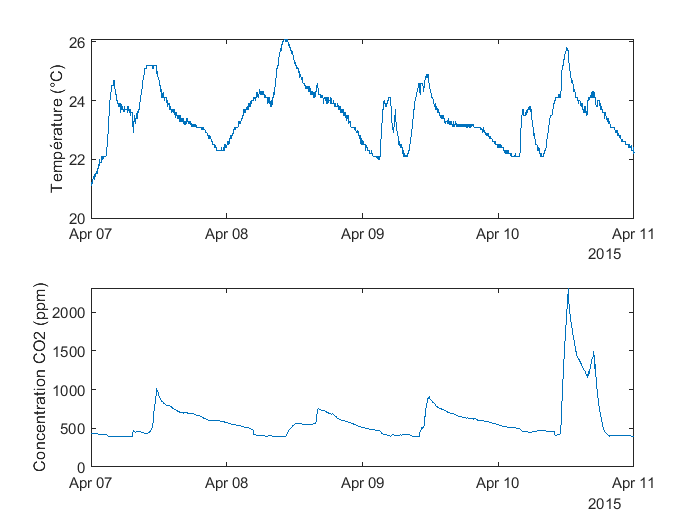

In [105]:
date_lim = [datetime(2015,04,07) datetime(2015,04,11)];

subplot(2,1,1)
plot(Temp_in.Time, Temp_in.value)
ylabel('Température (°C)')
xlim(date_lim)

subplot(2,1,2)
plot(CO2.Time, CO2.value)
ylabel('Concentration CO2 (ppm)')
xlim(date_lim)

Problème : que ce soit par l'extraction à la main via le logical indexing, ou bien avec `unstack`, les mesures des différents capteurs ne sont **pas synchronisées**.

Conséquence : impossible de faire des modèles (par ex. une régression d'une variable sur l'autre) ni même un simple nuage de point.

In [84]:
plot(Temp_in.Temp_in, CO2.CO2, ',')

Error using plot
Vectors must be the same length.


### Rééchantillonnage, agrégation et resynchronisation

#### Rééchantillonage 

avec [retime](https://fr.mathworks.com/help/matlab/ref/timetable.retime.html) :

Syntaxe 1 (la plus simple) :

```
TT2 = retime(TT1,newTimeStep)
TT2 = retime(TT1,newTimeStep,method)
```

avec :

* `newTimeStep` = 'daily', 'hourly', 'minutely'...
* `method` indique la méthode d'interpolation ou d'agrégation à utiliser :

  * Interpolation : 'nearest', 'previous' (~bloquage d'ordre zéro), 'linear'
  * Agrégation : 'mean', 'sum', 'max'… (lorsqu'on veut agréger statistiquement les données en utilisant un pas nettement plus long)

Styntaxe 2, pour pouvoir spécifier le pas de temps de façon plus fine
(Matlab ≥[R2018a](https://fr.mathworks.com/help/matlab/release-notes.html?category=data-analysis&rntext=retime&startrelease=R2018a&endrelease=R2018a&groupby=release&sortby=descending&searchHighlight=retime)) :

```
TT2 = retime(TT1,'regular',method,'TimeStep',dt)
TT2 = retime(TT1,'regular','TimeStep',dt)
```

avec `dt` une `duration` quelconque.

Remarque : on peut aussi rééchantillonner sur un vecteur temps quelconque passé en argument (syntaxe 3 : `TT2 = retime(TT1,newTimes,method)`)


Exemple : rééchantillonage à la minute avec `method='previous'` → crée un NaN pour à de 17:21, comme la première mesure date de 17:21:02

In [112]:
Temp_in_1m = retime(Temp_in, 'minutely', 'previous');
% Equivalent avec sntaxe 2 :
Temp_in_1m = retime(Temp_in, 'regular', 'previous', 'TimeStep', minutes(1));

% Comparaison avant après
disp(head(Temp_in, 3))
disp(head(Temp_in_1m, 8))

             Time              value
    _______________________    _____

    2015-03-09 17:21:02.496    23.4 
    2015-03-09 17:24:03.886    23.3 
    2015-03-09 17:27:03.094    23.3 

             Time              value
    _______________________    _____

    2015-03-09 17:21:00.000     NaN 
    2015-03-09 17:22:00.000    23.4 
    2015-03-09 17:23:00.000    23.4 
    2015-03-09 17:24:00.000    23.4 
    2015-03-09 17:25:00.000    23.3 
    2015-03-09 17:26:00.000    23.3 
    2015-03-09 17:27:00.000    23.3 
    2015-03-09 17:28:00.000    23.3 



Cependant, si on fait un retime pour chaque série individuellement, on ne pourra quand même pas forcément les concaténer, car les instants de début et de fin ne coincideront pas forcément. Il faut **synchroniser les données**.

#### Synchroniser des Timetables

Deux solutions :

* faire un `retime` sur `log_TT_unstack` qui contient déjà toutes les mesures dans des colonnes séparées. Cela va remplir les NaNs
* utiliser [synchronize](https://fr.mathworks.com/help/matlab/ref/timetable.synchronize.html) (⚠): *“Synchronize timetables to common time vector, and resample or aggregate data from input timetables”*

(⚠ fonction `synchronize` pour les objets `table`, à ne pas confondre avec [synchronize](https://fr.mathworks.com/help/matlab/ref/timeseries.synchronize.html) pour les objets `timeseries `)

Méthode 1 : `retime` sur une Timetable “unstacked”:

In [122]:
log_3m = retime(log_TT_unstack, 'regular', 'previous', 'TimeStep', minutes(3)); % ou method='nearest' si on veut aucun NaN
disp(head(log_3m, 10));

             Time              carbonDioxide    indoorRelativeHumidity    indoorTemperature    outdoorTemperature    solarIrradiance    volatileOrganicCompounds
    _______________________    _____________    ______________________    _________________    __________________    _______________    ________________________

    2015-03-09 17:18:00.000         NaN                  NaN                     NaN                   NaN                 NaN                     NaN          
    2015-03-09 17:21:00.000        1630                   36                     NaN                   NaN                 NaN                     NaN          
    2015-03-09 17:24:00.000        1630                   36                    23.4                   NaN                  11                     0.5          
    2015-03-09 17:27:00.000        1630                   36                    23.3                   NaN                  11                     0.5          
    2015-03-09 17:30:00.000      

Après ce rééchantillonnage, `isregular` renvoie bien true

In [123]:
disp(isregular(log_3m))

   1



La resynchro permet de faire des nuages de points par exemple (et puis ensuite des régressions et autre analyses)

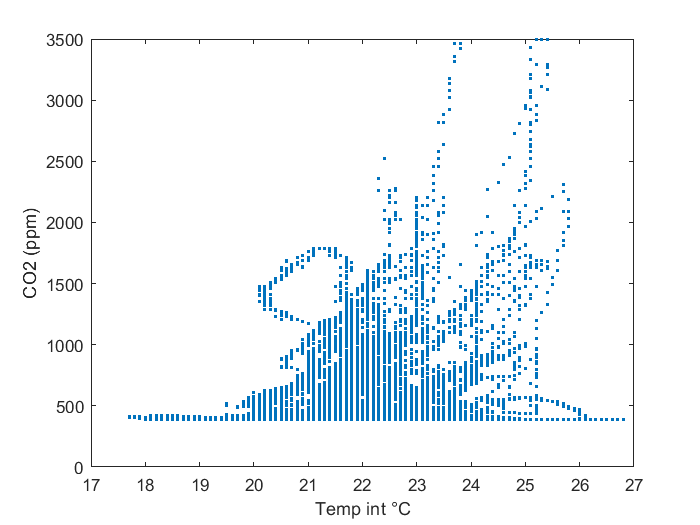

In [131]:
plot(log_3m.indoorTemperature, log_3m.carbonDioxide, '.')
xlabel('Temp int °C')
ylabel('CO2 (ppm)')

Le même nuage de point, mais avec `scatter`, ce qui permet d'uliser la transparence des points ([alpha](https://fr.mathworks.com/help/matlab/ref/alpha.html))

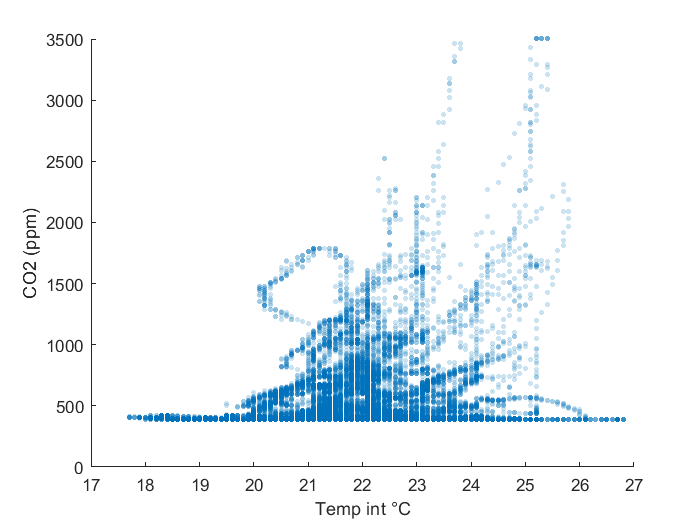

In [139]:
s = scatter(log_3m.indoorTemperature, log_3m.carbonDioxide, 'filled', 'SizeData',10);
xlabel('Temp int °C')
ylabel('CO2 (ppm)')
alpha(s, 0.2)

Méthode 2 : utiliser [synchronize](https://fr.mathworks.com/help/matlab/ref/timetable.synchronize.html)

Comme avec `retime`, il y a deux syntaxes pour indiquer le pas de temps :

Syntax 1, avec `newTimeStep` = 'daily', 'hourly', 'minutely'...

```
TT = synchronize(TT1,TT2,newTimeStep,method)
```

Syntaxe 2, plus flexible, où `dt` est n'importe quelle `duration` :

```
TT = synchronize(TT1,TT2,'regular',method,'TimeStep',dt)
```

Et on n'est pas limité à seulement 2 Timetables. On peut en synchroniser autant que désiré : `TT = synchronize(TT1,...,TTN,___)`


Accessoirement, il est possible d'utiliser la syntaxe
`TT = synchronize(TT1,TT2,newTimeBasis,method)`
où `newTimeBasis` peut être 'union' (*Union of the row times*), 'intersection' (*Intersection of the row times*) et quelques autres, au lieu de spécifier juste un pas de temps.

Application aux 3 Timetable extraites manuellement de log empilé. Le résultat est très similaire au précédent, mis à part le nom des colonnes (et bien sûr l'absence de certains capteurs)

In [141]:
log_3m2 = synchronize(Temp_in, Temp_out, CO2, 'regular', 'previous','TimeStep',  minutes(3));
disp(head(log_3m2, 10));

             Time              value_Temp_in    value_Temp_out    value_CO2
    _______________________    _____________    ______________    _________

    2015-03-09 17:18:00.000         NaN               NaN            NaN   
    2015-03-09 17:21:00.000         NaN               NaN           1630   
    2015-03-09 17:24:00.000        23.4               NaN           1630   
    2015-03-09 17:27:00.000        23.3               NaN           1630   
    2015-03-09 17:30:00.000        23.3               NaN           1630   
    2015-03-09 17:33:00.000        23.1             19.53           1650   
    2015-03-09 17:36:00.000        23.1             19.53           1640   
    2015-03-09 17:39:00.000        23.1             19.53           1630   
    2015-03-09 17:42:00.000        23.1             19.53           1630   
    2015-03-09 17:45:00.000          23             19.53           1630   



### Choix de la méthode de rééchantillonnage

Il n'y a pas de règle prédéterminée, c'est au cas par cas, en fonction de l'objectif visé, qu'il faut choisir sa méthode.

Par exemple, sur un même problème « Comparer la température extérieure (issue du capteur de la salle 404) vs la température à Rennes de l’archive météo »,
on peut utiliser deux stratégies : 

* interpoler les données à pas long (archive météo Δt = 1h) pour les comparer aux données à pas rapide (capteur salle 404 Δt ~ qq minutes)
* agréger les données rapides (par ex. par moyennage) pour les comparer aux données à pas long

La 2e solution génère bien sûr un tableau de données plus petit. Illustration de la méthode par agrégation

In [143]:
Temp_out_1h = retime(Temp_out, 'hourly', 'mean');
disp(head(Temp_out_1h, 3))

             Time              value
    _______________________    _____

    2015-03-09 17:00:00.000    19.53
    2015-03-09 18:00:00.000    19.35
    2015-03-09 19:00:00.000    18.67



In [163]:
Temp_out_cmp = synchronize(Temp_out_1h, meteo_TT(:,'Temp'), 'intersection');
% Renommage des colonnes
Temp_out_cmp.Properties.VariableNames{1} = 'Temp_ext_404';
Temp_out_cmp.Properties.VariableNames{2} = 'Temp_StJacques';

disp(head(Temp_out_cmp))

             Time              Temp_ext_404    Temp_StJacques
    _______________________    ____________    ______________

    2015-03-09 17:00:00.000        19.53            12.6     
    2015-03-09 18:00:00.000        19.35            10.4     
    2015-03-09 19:00:00.000        18.67             9.2     
    2015-03-09 20:00:00.000        18.05             8.2     
    2015-03-09 21:00:00.000        17.43             8.2     
    2015-03-09 22:00:00.000       17.175             8.1     
    2015-03-09 23:00:00.000           17             7.7     
    2015-03-10 00:00:00.000       16.825             7.3     



À présent, la comparaison peut se faire, par exemple avec un nuage de point

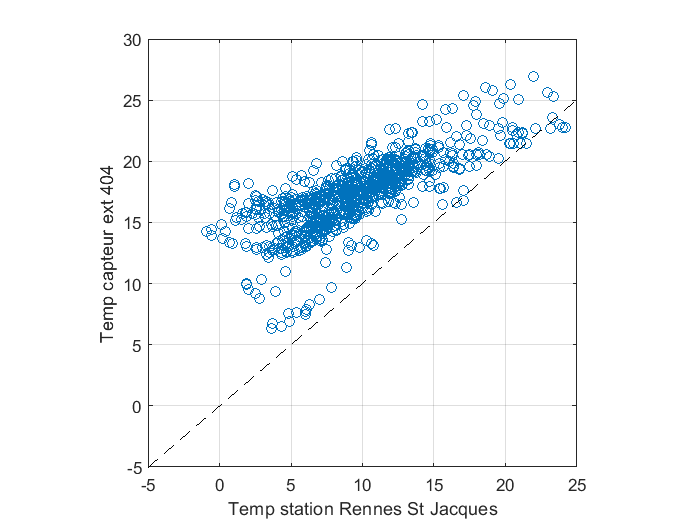

In [172]:
plot(Temp_out_cmp.Temp_StJacques, Temp_out_cmp.Temp_ext_404, 'o')
hold on
plot([-5 25], [-5 25], 'k--') % ligne de référence y=x
axis square
xlabel('Temp station Rennes St Jacques')
ylabel('Temp capteur ext 404')
grid

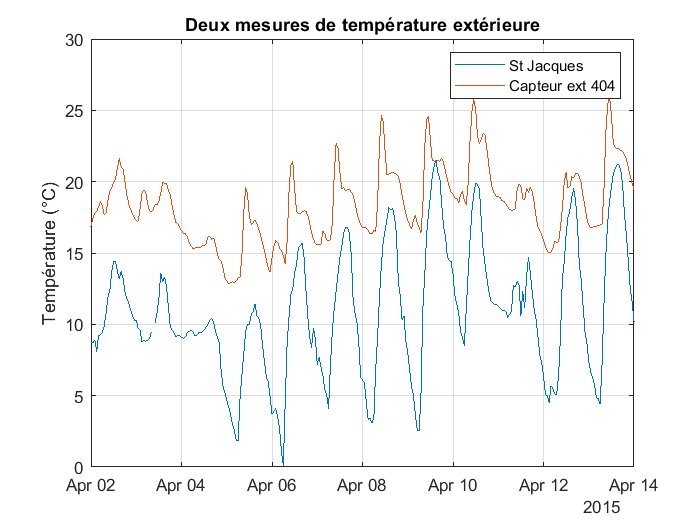

In [178]:
date_lim = [datetime(2015,04,02) datetime(2015,04,14)];

plot(Temp_out_cmp.Time, Temp_out_cmp.Temp_StJacques)
hold on
plot(Temp_out_cmp.Time, Temp_out_cmp.Temp_ext_404)

legend('St Jacques', 'Capteur ext 404')
title('Deux mesures de température extérieure')
ylabel('Température (°C)')
xlim(date_lim)
grid on

Commentaire : le capteur de température extérieure est posé sur le rebord de fenêtre, et ça se ressent... (et en plus : éclairement direct du soleil)

## 3) Recap final

Fichiers : fiche de présence salle 404 (et log qualité de l’air, archive météo)